# Seasonality of Electrictiy Used by One French Household
### By Steven Cozine & Christina Nguyen
Link to Github Repo: https://github.com/cnguyen0329/DSE230_FinalProject

## General Background of Data Set and Problem Statement

### Background of the data set
This data set is the collection of electricity consumption of one French household (living 7km from Paris) over the span of 47 months (December 2006 to November 2010).  
Notes (from the data collectors):   
1. (global_active_power*1000/60 - sub_metering_1 - sub_metering_2 - sub_metering_3) represents the active energy consumed every minute (in watt hour) in the household by electrical equipment not measured in sub-meterings 1, 2 and 3.  
2. The dataset contains some missing values in the measurements (nearly 1,25% of the rows). All calendar timestamps are present in the dataset but for some timestamps, the measurement values are missing: a missing value is represented by the absence of value between two consecutive semi-colon attribute separators.  

There are these electricity metrics:  
1. Global active power  
    * Household global minute-averaged active power (in kilowatt).  
    * Active power is the power which is dissipated or do the useful work in the circuit - the real power  
2. Global reactive power
    * Household global minute-averaged reactive power (in kilowatt).   
    * Reactive power is the power that moves between the source and the load of the circuit - it is not doing any useful works on the load.  
3. Voltage
    * Minute-averaged voltage (in volt).  
    * It is the difference in electric potential between two points  
4. Global intensity 
    * Household global minute-averaged current intensity (in ampere).   
5. Sub-metering 1  
    * Energy sub-metering of a specific room (in watt-hour of active energy).  
    * Corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).  
6. Sub-metering 2  
    * Energy sub-metering of a specific room (in watt-hour of active energy).  
    * Corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.  
7. Sub-metering 3  
    * Energy sub-metering of a specific room (in watt-hour of active energy).  
    * Corresponds to an electric water-heater and an air-conditioner.  

Links to electricity background info:  
https://circuitglobe.com/electric-power.html  
https://circuitglobe.com/difference-between-active-and-reactive-power.html  
https://en.wikipedia.org/wiki/Voltage  

### What problem(s) or question(s) are we trying to answer with the analysis? 
Seasonality of electricity consumption - by knowing this, electricity companies are able to better determine when to increase electricity generation and to plan brownouts or rolling blackouts to ensure stability to the electrical grid.  

We will answer this with two different anaylsis pipelines:  
1. Cluster analysis  
    To determine if electricity consumpton by date and hour share characteristics that can be shown by clustering.  
    For example, electricity consumption might differ through the seasons like the summer months will see more usage of an air conditioner. This can be applied to hourly consumption as well as an air conditioner might not be utilized at night as nighttime is cooler compared to the daytime.  

2. Linear regression  
    To predict electricity consumption in the future from the 47 months of data that we have.  
    This would aid in pinpointing a number or a range of values that electricity companies need to generate for a specific date.
    
### Background info to aid with our analysis
We include the average temperatures of Paris to provide more background information and to determine if electricity usage is perhaps tied with warmer or cooler weather. 

![Average Temperatures in Paris](average-temperature-c-gr.jpeg)

Link to site: https://www.worldweatheronline.com/paris-weather-averages/ile-de-france/fr.aspx

### Reading in the appropriate libraries and starting the dask client.

In [1]:
## Run these cells to run the Dask version we used to develop this project

!pip3 install --upgrade dask==2021.5.1

     |████████████████████████████████| 964 kB 3.2 MB/s eta 0:00:01
  Attempting uninstall: dask
    Found existing installation: dask 2021.3.0
    Uninstalling dask-2021.3.0:
      Successfully uninstalled dask-2021.3.0


In [2]:
!pip3 install --upgrade dask[distributed]==2021.5.1

Requirement already up-to-date: dask[distributed]==2021.5.1 in /usr/local/lib/python3.8/dist-packages (2021.5.1)
     |████████████████████████████████| 705 kB 3.0 MB/s eta 0:00:01
  Attempting uninstall: distributed
    Found existing installation: distributed 2021.3.0
    Uninstalling distributed-2021.3.0:
      Successfully uninstalled distributed-2021.3.0


In [3]:
import numpy as np
import pandas as pd
import datetime
import time
import matplotlib.pyplot as plt 
%matplotlib inline

## Import in the dask machine learning libraries
from dask_ml import preprocessing ## for standardscalar
from dask_ml import model_selection ## for train test split
from dask_ml import cluster ## for KMeans
from copy import copy
from dask_ml import preprocessing as pp
from dask_ml.model_selection import train_test_split
from dask_ml.linear_model import LinearRegression
import dask.dataframe as dd
import dask.array as da
import joblib
from dask.distributed import Client

In [4]:
start = time.time()

client = Client(n_workers = 8)

client

Client Scheduler: tcp://127.0.0.1:46767 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 8 Cores: 8 Memory: 15.23 GiB


## Description of Data 
These are all the columns from the original data set with the exception that we combined the date and time columns to become date_time - we made note of the electricity features in the previous section. 
We dropped any row that had "NaN" or "NA" with dropna() and printed out the number of rows removed from the original data set. 

### Reading in Data Set for Cluster Analysis:
As part of the EDA, we are aggregating the electricity metrics to a month level and a hour level to separate dataframes. The hour level is interesting as electricity consumption varies throughout the day.  

In [5]:
%%time

parse_dates = [['Date','Time']]

df = dd.read_csv('./household_power_consumption.txt', sep = ';',
                 dtype={'Global_active_power': 'object',
               'Global_intensity': 'object',
               'Global_reactive_power': 'object',
               'Sub_metering_1': 'object',
               'Sub_metering_2': 'object',
               'Sub_metering_3': 'object',
               'Voltage': 'object'}, parse_dates=parse_dates,
                infer_datetime_format = True)

kmeans_df = df.dropna()
kmeans_df = kmeans_df.astype({'Global_active_power': 'float64', 'Global_reactive_power': 'float64', 'Voltage': 'float64', 'Global_intensity': 'float64', 'Sub_metering_1': 'float64', 'Sub_metering_2': 'float64', 'Sub_metering_3':'float64'})

CPU times: user 51.2 ms, sys: 5.52 ms, total: 56.8 ms
Wall time: 55 ms


In [6]:
persist_df = client.persist(df)

### Shape and statistics of the cluster data set: 

In [7]:
dd_shape_o = df.shape
dd_shape_o[0].compute(),dd_shape_o[1]

(2075259, 8)

In [8]:
dd_shape = kmeans_df.shape
dd_shape[0].compute(),dd_shape[1]

(2049280, 8)

In [9]:
print("Difference once removing all NaNs/NAs from data set: ", (dd_shape_o[0]-dd_shape[0]).compute())

Difference once removing all NaNs/NAs from data set:  25979


In [10]:
kmeans_df.describe().compute()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.720000e-01,5.400000e-02,2.400100e+02,1.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,9.080000e-01,1.020000e-01,2.417400e+02,3.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.626000e+00,2.000000e-01,2.440300e+02,6.800000e+00,0.000000e+00,1.000000e+00,1.800000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [11]:
kmeans_df['month'] = kmeans_df['Date_Time'].dt.month
kmeans_df['hour'] = kmeans_df['Date_Time'].dt.hour

In [12]:
%%time

month_df = kmeans_df.groupby('month').sum().compute()
hour_df = kmeans_df.groupby('hour').sum().compute()

CPU times: user 12.6 s, sys: 1.79 s, total: 14.4 s
Wall time: 3min 29s


### Creating Data Set for Regression Analysis:

We separated the two analysis with two different Dask DataFrames to aid in working collaboratively and to help us to keep track of our analysis easily.  

In [13]:
## Copying the Dask Dataframe to a separate dask dataframe that we will use for the regression model
regression_df = copy(df)

In [14]:
## Our goal for the regression model is to predict the energy usage for a given hour in a day
## So first we will reextract the date feature, 
## and also extract the hour (0-23)
regression_df['Date'] = regression_df['Date_Time'].dt.date
regression_df['Hour'] = regression_df['Date_Time'].dt.hour

In [15]:
## We have about 1.25% nulls or invalid entries in our original dataset, so we will drop those now
regression_df = regression_df.dropna()

#### Global active power is a function of features such as global reactive power, global intensity, voltage, and submetering.  
#### So by keeping those features, we would expose our model to data leakage.
#### Therefore, it does not make sense to use non-datetime features for this regression analysis, even though it would give us a better accuracy.

In [16]:
## Cutting our dataframe into only datetime features and our target
regression_features = ['Date','Hour','Global_active_power']
regression_df = regression_df[regression_features]
regression_df = regression_df.astype({'Date': 'datetime64', 'Hour': 'int64', 'Global_active_power': 'float64'})

## And summing these features by hour
regression_dfgb = regression_df.groupby(by=['Date','Hour']).sum()
regression_dfgb = regression_dfgb.reset_index()
regression_dfgb = regression_dfgb.astype({'Date': 'datetime64', 'Hour': 'int64', 'Global_active_power': 'float64'})

#### We need to convert our Date field into features we can perform regression on.

In [17]:
regression_dfgb['Year'] = regression_dfgb['Date'].dt.year
regression_dfgb['Month'] = regression_dfgb['Date'].dt.month
regression_dfgb['DoM'] = regression_dfgb['Date'].dt.day

#### Now that our date column is split into Year, Month, Day, and Hour, our features are usable in a regression model.  
#### However, in doing so, our regression model had a poor R2 score of 0.08. Technically correlated with global active power, but we can do better.  
#### So, we need better, more predictive datetime features.  

In [18]:
regression_dfgb['Quarter'] = regression_dfgb['Date'].dt.quarter
regression_dfgb['DoY'] = regression_dfgb['Date'].dt.dayofyear
regression_dfgb['DoW'] = regression_dfgb['Date'].dt.dayofweek

In [19]:
## We will use our Day of Week feature to create a weekend feature: 0 for weekdays, and 1 for weekends
## The logic here being that, families will act differently on weekends, and so their energy usage will change.
## This feature will hopefully capture some of that correlation.
weekenddict={0:0,1:0,2:0,3:0,4:0,5:1,6:1}
regression_dfgb['Weekend'] = regression_dfgb.DoW.map(weekenddict)

## A night hours feature will flag the hours from 11PM to 6AM - traditionally times in which families are asleep
## So this feature should correlate with low electricity usage
nightdict={0:1,1:1,2:1,3:1,4:1,5:1,6:1,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0,15:0,16:0,17:0,18:0,19:0,20:0,21:0,22:0,23:1}
regression_dfgb['Night Hours'] = regression_dfgb.Hour.map(nightdict)

## A peak hours feature will flag the hours from 6PM to 10PM, hours in which everybody is home and using electricity to cook dinner or as it gets dark
## This feature should correlate with high electricity usage
peakdict={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:0,8:0,9:0,10:0,11:0,12:0,13:0,14:0,15:0,16:0,17:0,18:1,19:1,20:1,21:1,22:1,23:0}
regression_dfgb['Peak Hours'] = regression_dfgb.Hour.map(peakdict)

## Similar to peak hours, a morning hours feature should capture that adults and children will use electricity as they wake up and prepare breakfast,
## before they leave the house for work or school
## This feature should correlate with medium-high electricity usage
morningdict={0:0,1:0,2:0,3:0,4:0,5:0,6:0,7:1,8:1,9:1,10:0,11:0,12:0,13:0,14:0,15:0,16:0,17:0,18:0,19:0,20:0,21:0,22:0,23:0}
regression_dfgb['Morning Hours'] = regression_dfgb.Hour.map(morningdict)

In [20]:
## Persisting the dataframe for performance
regression_dfgb = regression_dfgb.persist()

### EDA of Monthly Aggregated Data Set:

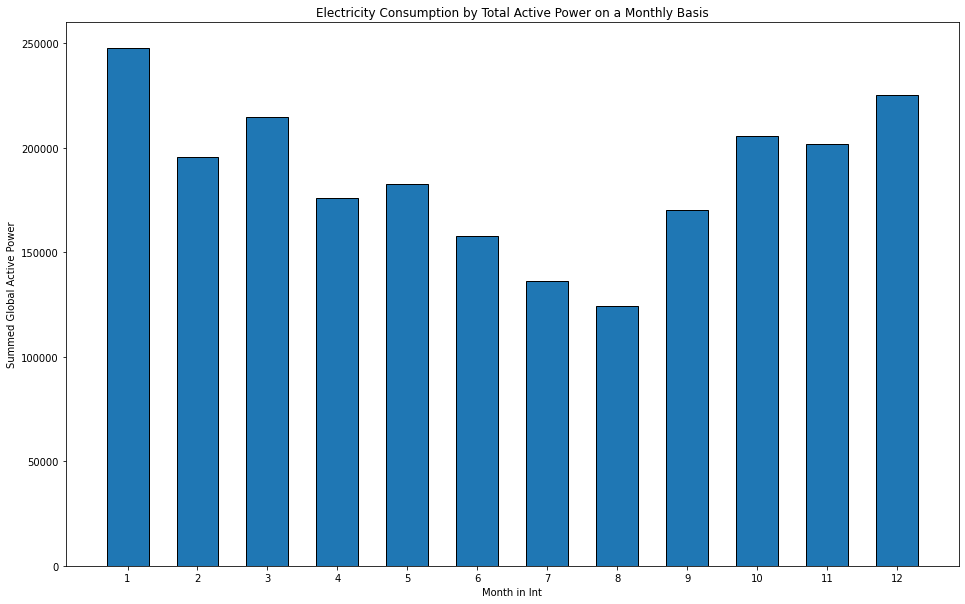

In [21]:
plt.figure(figsize=(16, 10))

plt.bar(month_df.index, month_df['Global_active_power'], color = 'tab:blue', width = 0.6, edgecolor = 'black', label = 'Total active power')
plt.title('Electricity Consumption by Total Active Power on a Monthly Basis')
plt.xticks(month_df.index)
plt.xlabel('Month in Int')
plt.ylabel('Summed Global Active Power')
plt.show()

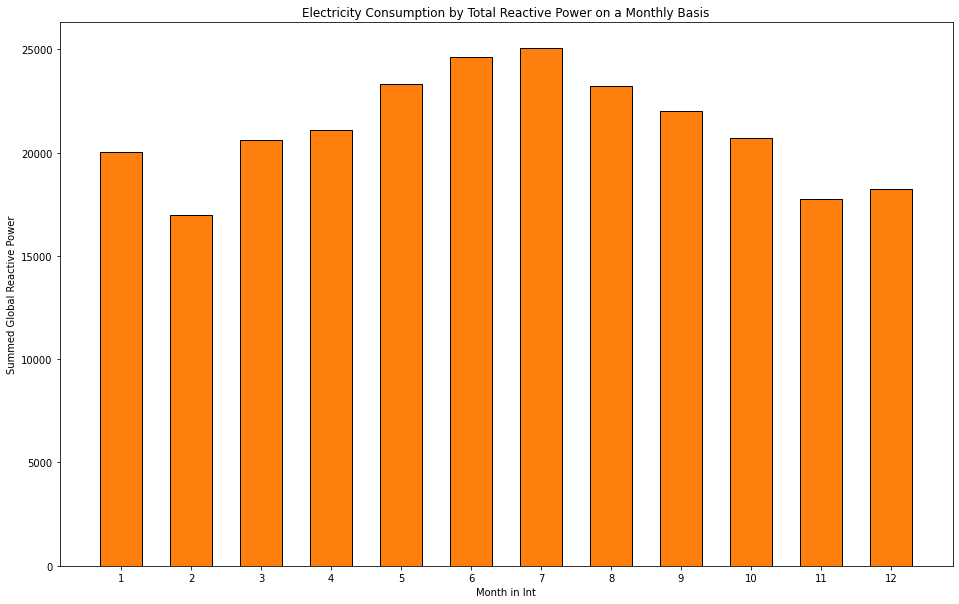

In [22]:
plt.figure(figsize=(16, 10))

plt.bar(month_df.index, month_df['Global_reactive_power'], color = 'tab:orange', width = 0.6, edgecolor = 'black', label = 'Total reactive power')
plt.title('Electricity Consumption by Total Reactive Power on a Monthly Basis')
plt.xticks(month_df.index)
plt.xlabel('Month in Int')
plt.ylabel('Summed Global Reactive Power')
plt.show()

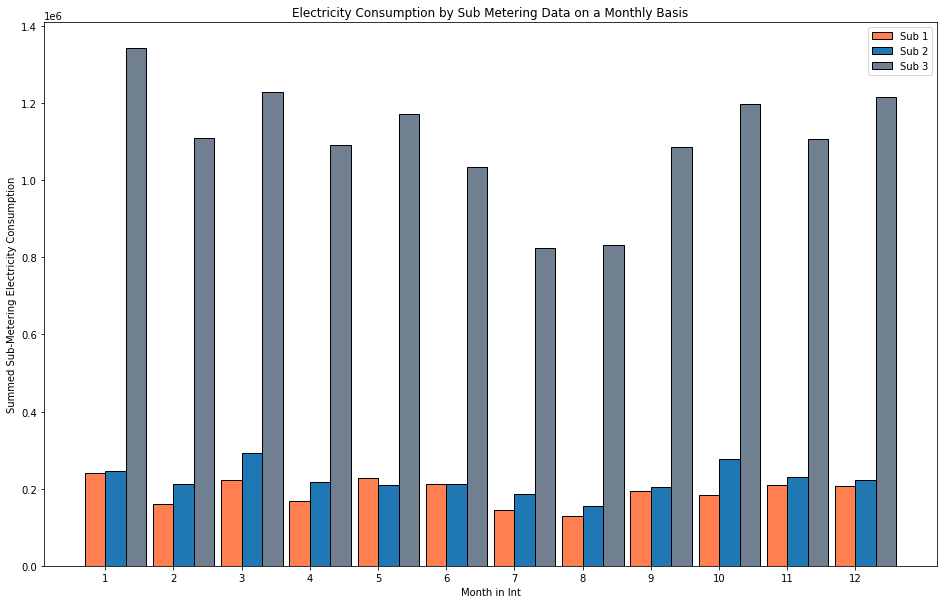

In [23]:
plt.figure(figsize=(16, 10))

width = 0.3
plt.bar(month_df.index, month_df['Sub_metering_1'], color = 'coral', width = -width, edgecolor = 'black', align = 'edge', label = 'Sub 1')
plt.bar(month_df.index + width, month_df['Sub_metering_2'], color = 'tab:blue', width = -width, edgecolor = 'black', align = 'edge', label = 'Sub 2')
plt.bar(month_df.index + 2*width, month_df['Sub_metering_3'], color = 'slategray', width = -width, edgecolor = 'black', align = 'edge', label = 'Sub 3')
plt.title('Electricity Consumption by Sub Metering Data on a Monthly Basis')
plt.xlabel('Month in Int')
plt.ylabel('Summed Sub-Metering Electricity Consumption')
plt.legend()
plt.xticks(month_df.index)
plt.show()

Global active power and sub-metering 3 seems to follow a similar trend when looking at the graphs - the peak months seem to be related to the fall and winter months (month # 10-3) , while the summer months (month # 6-8) have the least consumption. 

Global reactive power shows a slight trend where the warmer months (month # 5-8) are higher than the other months. That graph follows similarly to the average weather in Paris graph that we showed previously. 

### EDA of Hourly Aggregated Data Set:

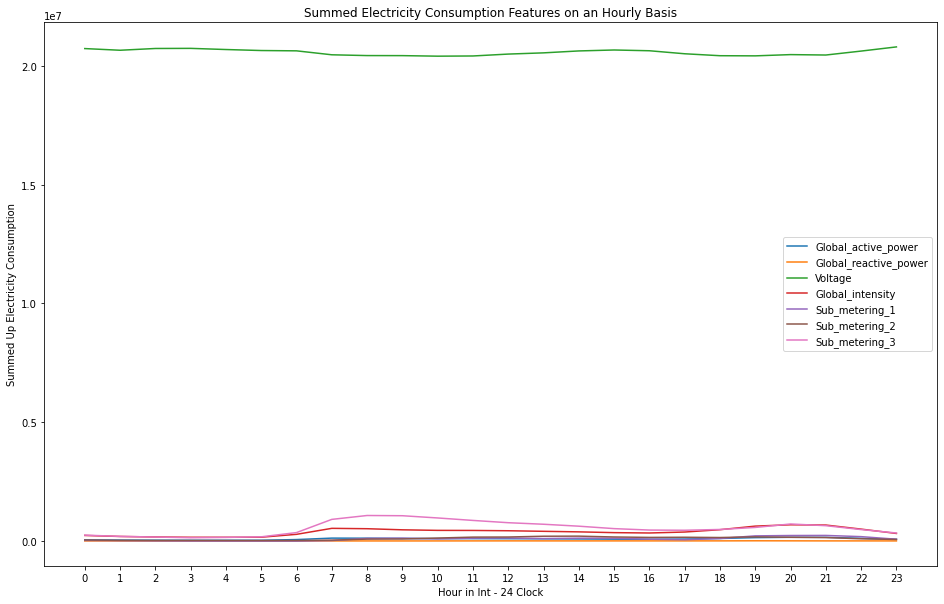

In [24]:
features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

plt.figure(figsize=(16, 10))

for feature in features: 
    plt.plot(hour_df.index, hour_df[feature], label = feature, alpha = 1)
plt.legend()
plt.xticks(hour_df.index)
plt.title('Summed Electricity Consumption Features on an Hourly Basis')
plt.xlabel('Hour in Int - 24 Clock')
plt.ylabel('Summed Up Electricity Consumption')
plt.show()

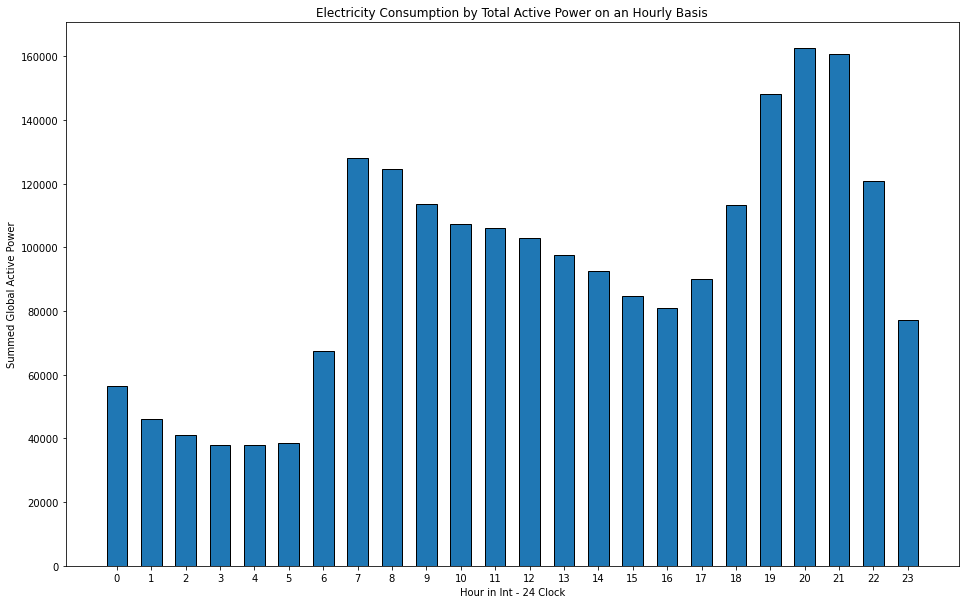

In [25]:
plt.figure(figsize=(16, 10))

plt.bar(hour_df.index, hour_df['Global_active_power'], color = 'tab:blue', width = 0.6, edgecolor = 'black', label = 'Total active power')
plt.title('Electricity Consumption by Total Active Power on an Hourly Basis')
plt.xticks(hour_df.index)
plt.xlabel('Hour in Int - 24 Clock')
plt.ylabel('Summed Global Active Power')
plt.show()

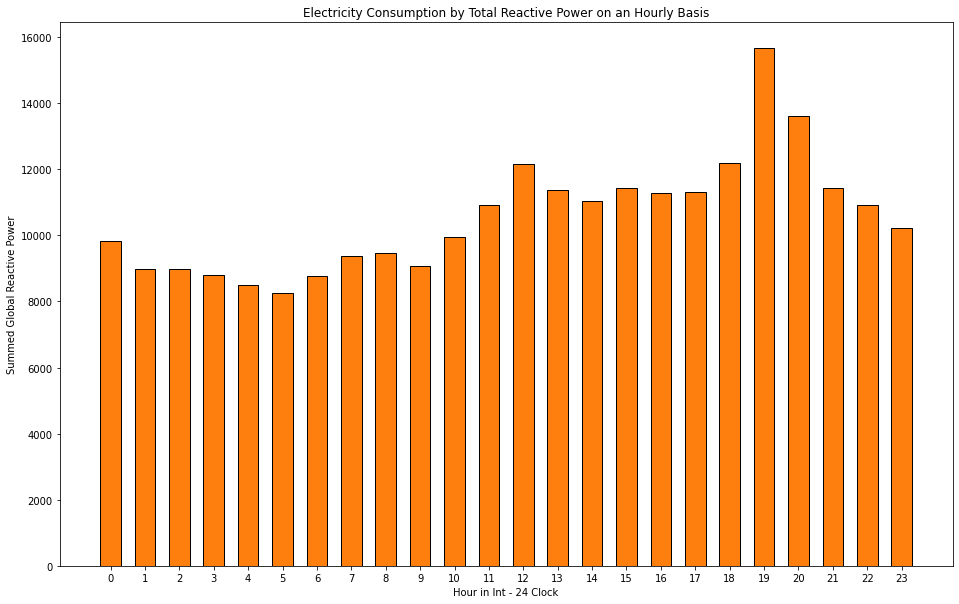

In [26]:
plt.figure(figsize=(16, 10))

plt.bar(hour_df.index, hour_df['Global_reactive_power'], color = 'tab:orange', width = 0.6, edgecolor = 'black', label = 'Total reactive power')
plt.title('Electricity Consumption by Total Reactive Power on an Hourly Basis')
plt.xticks(hour_df.index)
plt.xlabel('Hour in Int - 24 Clock')
plt.ylabel('Summed Global Reactive Power')
plt.show()

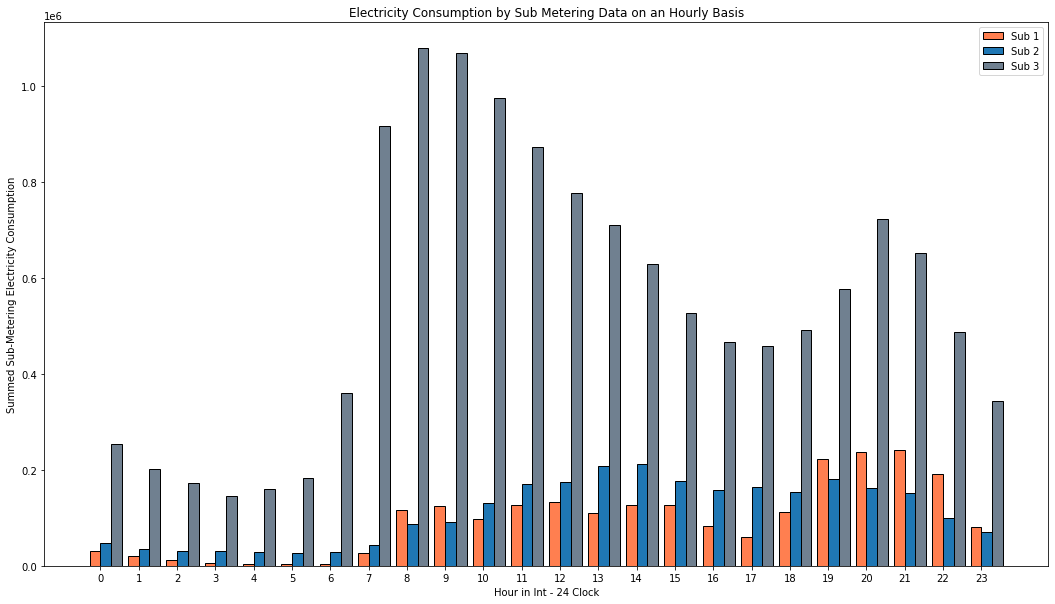

In [27]:
plt.figure(figsize=(18, 10))

width = 0.28
plt.bar(hour_df.index, hour_df['Sub_metering_1'], color = 'coral', width = -width, edgecolor = 'black', align = 'edge', label = 'Sub 1')
plt.bar(hour_df.index + width, hour_df['Sub_metering_2'], color = 'tab:blue', width = -width, edgecolor = 'black', align = 'edge', label = 'Sub 2')
plt.bar(hour_df.index + 2*width, hour_df['Sub_metering_3'], color = 'slategray', width = -width, edgecolor = 'black', align = 'edge', label = 'Sub 3')
plt.title('Electricity Consumption by Sub Metering Data on an Hourly Basis')
plt.xlabel('Hour in Int - 24 Clock')
plt.ylabel('Summed Sub-Metering Electricity Consumption')
plt.legend()
plt.xticks(hour_df.index)
plt.show()

From just graphing all the electricity features on the same graph, it was difficult to gleam much from it. The voltage metric is incredibly high compared to the other metrics. Scaling these features would aid in the kmeans clustering.  

For the hourly aggregration, we see very distinct groupings or clustering of electricity consumption based from sub-metering 3 and global active power.  

Just from the graphs, we can kind of see these general groups:  
1. Hours 0-6  
2. Hours 7-15  
3. Hours 16-23  

Once we run kmeans, hopefully we will be able to verify if these groupings are accurate or similar.  

## Running KMeans Clustering 

Based from the EDA, it seems that using sub-metering 3 and global active power is the way to go for electricity features used, however, we will run the first KMeans run on all available electricity features and do clustering based on the groups we mentioned above. 

For the second KMeans run we will be using three features: hour (created from date_time), sub-metering 3, and global active power.  

### KMeans on all features

In [28]:
%%time

groups_dict = {0:1,1:1,2:1,3:1,4:1,5:1,6:1,7:2,8:2,9:2,10:2,11:2,12:2,13:2,14:2,15:2,16:3,17:3,18:3,19:3,20:3,21:3,22:3,23:3}

kmeans_df['HourGroups'] = kmeans_df.hour.map(groups_dict)

persist_df = kmeans_df.persist()

CPU times: user 12.4 ms, sys: 861 µs, total: 13.2 ms
Wall time: 12.9 ms


In [29]:
%%time

features = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

daskScaler = preprocessing.StandardScaler()
data = persist_df[features]
data_array = data.to_dask_array()
data_array = data_array.compute_chunk_sizes()

label = persist_df['HourGroups']
label_array = label.to_dask_array()
label_array = label_array.compute_chunk_sizes()


x_train, x_test, y_train, y_test = model_selection.train_test_split(data_array, label_array, shuffle = True, test_size = 0.33, random_state = 42)

trainScaler = daskScaler.fit_transform(x_train)
testScaler = daskScaler.transform(x_test)

CPU times: user 8.57 s, sys: 1.31 s, total: 9.88 s
Wall time: 2min 4s


In [30]:
%%time

kmeans = cluster.KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(trainScaler)

x_train_pred = kmeans.predict(trainScaler)
x_test_pred = kmeans.predict(testScaler)

train_score = np.mean(x_train_pred == y_train)
test_score = np.mean(x_test_pred == y_test)

print("All features train score: ", train_score.compute())
print("All features test score: ", test_score.compute())

All features train score:  0.3026306302106966
All features test score:  0.3025302286240708
CPU times: user 6.71 s, sys: 751 ms, total: 7.46 s
Wall time: 34.2 s


### Determining best cluster to use for KMeans model

In order to determine the best number of clusters to use for the model, we need to determine the best SSE value (the lower the better).

In [31]:
%%time
## Running elbow method to determine best k value for n_clusters parameter

sse = []

features_3 = ['hour', 'Global_active_power', 'Sub_metering_3']

data3 = persist_df[features_3]
dd_scaled3 = daskScaler.fit_transform(data3)

for k in range(1, 11):
    dask_kmeans = cluster.KMeans(n_clusters = k, random_state = 42)
    dask_kmeans.fit(dd_scaled3)
    sse.append(dask_kmeans.inertia_)

CPU times: user 48.2 s, sys: 6.25 s, total: 54.4 s
Wall time: 3min 59s


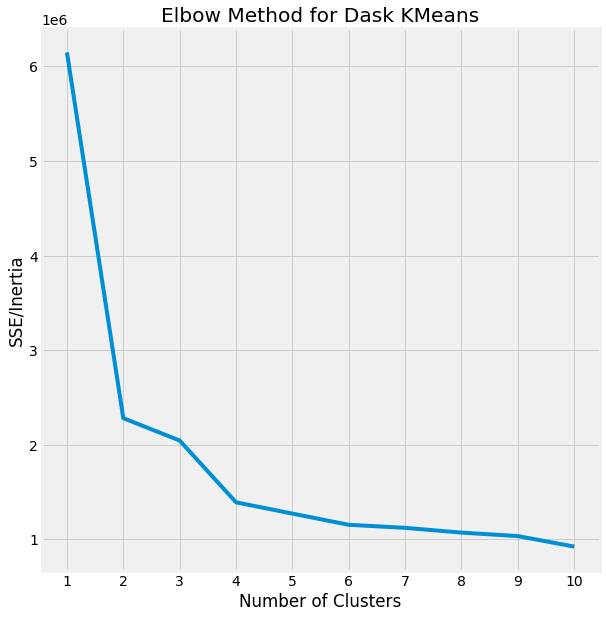

In [32]:
plt.figure(figsize=(10, 10))
plt.style.use('fivethirtyeight')
plt.plot(range(1,11), sse)
plt.xticks(range(1,11))
plt.xlabel('Number of Clusters')
plt.ylabel('SSE/Inertia')
plt.title('Elbow Method for Dask KMeans')
plt.show()

From the elbow method - it seems that 3 or 4 clusters are the best numbers to set for the number of clusters for the model, we will run both values.  

The next part we will run the KMeans model on the 3 features we selected (hour, global active power, and sub-metering 3).

### KMeans on selected features - hour, global active power, and sub-metering 3 and using 3 as the number of clusters.

In [33]:
%%time

features_3 = ['hour', 'Global_active_power', 'Sub_metering_3']

data3 = persist_df[features_3]
data_array = data3.to_dask_array()
data_array = data_array.compute_chunk_sizes()

x_train, x_test, y_train, y_test = model_selection.train_test_split(data_array, label_array, shuffle = True, test_size = 0.1, random_state = 42)

trainScaler = daskScaler.fit_transform(x_train)
testScaler = daskScaler.transform(x_test)

kmeans = cluster.KMeans(n_clusters = 3, random_state = 42)
kmeans.fit(trainScaler)

train_pred = kmeans.predict(trainScaler)
test_pred = kmeans.predict(testScaler)

train_score = np.mean(train_pred == y_train)
test_score = np.mean(test_pred == y_test)

print("3 selected features train score: ", train_score.compute())
print("3 selected features test score: ", test_score.compute())

3 selected features train score:  0.46337925915403305
3 selected features test score:  0.4656149202894661
CPU times: user 5.62 s, sys: 605 ms, total: 6.22 s
Wall time: 26.9 s


When running KMeans on the selected features with number of clusters set to 3, there is a 41% accuracy score when comparing KMeans predictions to the manual groupings we determined in the EDA part.  


### KMeans on selected features - hour, global active power, and sub-metering 3 and using 4 as the number of clusters.
Next we run it on number of clusters set to 4 instead and we have adjusted the manual groupings of the electricity consumption hours to be this instead:  
1. Hours 0-6
2. Hours 7-12
3. Hours 13-19
4. Hours 20-23

In [34]:
groups_dict = {0:1,1:1,2:1,3:1,4:1,5:1,6:1,7:2,8:2,9:2,10:2,11:2,12:2,13:3,14:3,15:3,16:3,17:3,18:3,19:3,20:4,21:4,22:4,23:4}

kmeans_df['HourGroups4'] = kmeans_df.hour.map(groups_dict)

persist_df = kmeans_df.persist()

In [35]:
%%time

features_3 = ['hour', 'Global_active_power', 'Sub_metering_3']

data3 = persist_df[features_3]
data_array = data3.to_dask_array()
data_array = data_array.compute_chunk_sizes()

label = persist_df['HourGroups4']
label_array = label.to_dask_array()
label_array = label_array.compute_chunk_sizes()

x_train, x_test, y_train, y_test = model_selection.train_test_split(data_array, label_array, shuffle = True, test_size = 0.1, random_state = 42)

trainScaler = daskScaler.fit_transform(x_train)
testScaler = daskScaler.transform(x_test)

kmeans = cluster.KMeans(n_clusters = 4, random_state = 42)
kmeans.fit(trainScaler)

train_pred = kmeans.predict(trainScaler)
test_pred = kmeans.predict(testScaler)

train_score = np.mean(train_pred == y_train)
test_score = np.mean(test_pred == y_test)

print("3 selected features train score: ", train_score.compute())
print("3 selected features test score: ", test_score.compute())

3 selected features train score:  0.03205843139402424
3 selected features test score:  0.03178661878016289
CPU times: user 5.65 s, sys: 645 ms, total: 6.3 s
Wall time: 27.7 s


So it seems that 3 or 4 clusters yield poor scores so we are switching gears to see if clustering would be able to cluster by hours in a day (0-23). For this we will add 1 to the hour/label array to line up with the cluster value.  

### KMeans on selected features - hour, global active power, and sub-metering 3 and using 24 as the number of clusters.

In [36]:
%%time

features_3 = ['hour', 'Global_active_power', 'Sub_metering_3']

data3 = persist_df[features_3]
data_array = data3.to_dask_array()
data_array = data_array.compute_chunk_sizes()

label = persist_df['hour']
label_array = label.to_dask_array()
label_array = label_array.compute_chunk_sizes()
label_array = 1 + label_array

x_train, x_test, y_train, y_test = model_selection.train_test_split(data_array, label_array, shuffle = True, test_size = 0.1, random_state = 42)

trainScaler = daskScaler.fit_transform(x_train)
testScaler = daskScaler.transform(x_test)

kmeans = cluster.KMeans(n_clusters = 24, random_state = 42)
kmeans.fit(trainScaler)

train_pred = kmeans.predict(trainScaler)
test_pred = kmeans.predict(testScaler)

train_score = np.mean(train_pred == y_train)
test_score = np.mean(test_pred == y_test)

print("3 selected features train score: ", train_score.compute())
print("3 selected features test score: ", test_score.compute())

3 selected features train score:  0.07223408125676728
3 selected features test score:  0.07117587066740189
CPU times: user 13.1 s, sys: 1.39 s, total: 14.5 s
Wall time: 1min 8s


### Regression Analysis
Here is the section using the regression_dfgb DataFrame instead - we persisted this DataFrame in the data clean-up section.  

In [37]:
## Splitting our features from our target
X_reg = regression_dfgb[['Year', 'Month', 'DoM', 'Hour', 'DoY', 'Quarter', 'DoW', 'Weekend', 'Morning Hours', 'Night Hours', 'Peak Hours']]
y_reg = regression_dfgb[['Global_active_power']]

In [38]:
%%time
## Converting to dask array so we can index on it by row number
## This takes a minute if it's the first run-through of the notebook
X_reg = X_reg.to_dask_array()
y_reg = y_reg.to_dask_array()
X_reg.compute_chunk_sizes()
y_reg.compute_chunk_sizes()

CPU times: user 27.1 ms, sys: 7.88 ms, total: 35 ms
Wall time: 45.8 ms


dask.array<values, shape=(33830, 1), dtype=float64, chunksize=(33830, 1), chunktype=numpy.ndarray>

In [39]:
## Setting up the model to fit on most of our data, and score on the last week of our dataset
timeslice = 24*7

X_train_reg = X_reg[:-timeslice,:]
X_test_reg = X_reg[-timeslice:,:]
y_train_reg = y_reg[:-timeslice,:]
y_test_reg = y_reg[-timeslice:,:]

## Uncomment below to use traditional 80/20 train test split instead
#X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, train_size = 0.8, test_size=0.2)

In [40]:
## Fitting our scaler to our train data
daskscaler = pp.StandardScaler()
daskscaler.fit(X_train_reg)

StandardScaler()

In [41]:
## Scaling our train and test data
X_train_reg = daskscaler.transform(X_train_reg)
X_test_reg = daskscaler.transform(X_test_reg)

In [42]:
## Creating and fitting our regression model
reg1 = LinearRegression()
reg1.fit(X_train_reg,y_train_reg)

LinearRegression()

In [43]:
## Scoring our regression model
print(reg1.score(X_test_reg,y_test_reg))

0.3917902507261092


In [44]:
## Getting predictions so we can compare visually with our target
preds = reg1.predict(X_test_reg)

In [45]:
## Doing a bit of trickery to get our X labels
regplot = regression_dfgb[['Date', 'Hour']].compute()

In [46]:
regplot = regplot.sort_values(by=['Date','Hour'])

In [47]:
regplot = regplot.astype({'Date': 'str', 'Hour': 'str'})
regplot['plot index'] = regplot['Date'] + " " + regplot['Hour'] + ":00"

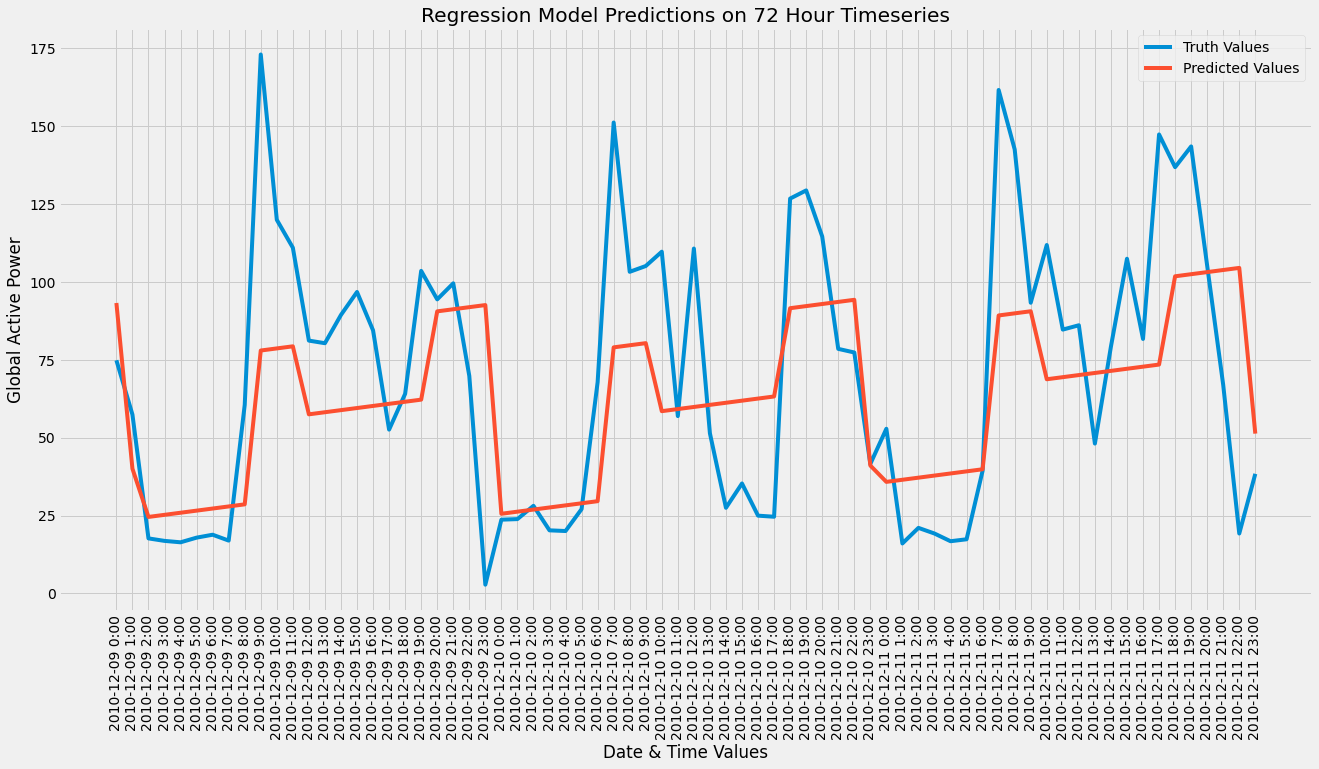

In [48]:
## Plotting a timeseries graph 
plt.figure(figsize=(20,10))
plt.plot(regplot['plot index'].iloc[len(regplot)-72:], y_test_reg[-72:], label="Truth Values");
plt.plot(regplot['plot index'].iloc[len(regplot)-72:], preds[-72:], label="Predicted Values");
plt.xticks(rotation = 90);
plt.xlabel("Date & Time Values")
plt.ylabel("Global Active Power")
plt.title("Regression Model Predictions on 72 Hour Timeseries")
plt.legend()
plt.show()

## Summary of Challenges and Solutions

1. Using Dask on local machines - Dask libraries (specifically the sklearn counterparts) run quite slow if Dask is not set up properly.  
    * We fixed a lot of our performance issues by using persist() on our final cleaned up Dask DataFrame and converting to Dask array to utilize array indexing. 
2. Starting from the Date_Time feature was a bottleneck as we created many features from that column specifically.  
3. Understanding the difference between the Dask libraries and the sklearn libraries. 
    * For example, KMeans clustering is quicker in Dask as the Dask Kmeans default is set to parallelizing but sklearn KMeans also has a means of parallelizing. 
    * Numpy indexing and Pandas dataframe indexing were stuff we missed while using Dask DataFrames but we figured it out eventually.  

## Analysis Results and Insights Gained

### Our KMeans clustering scores finalized to be:
| Number of Features Used | Number of Clusters | Test Score |
| :-: | :-: | :-: |
| All Electricity Features Used | 3 | 0.3025302286240708 | 
| 3 Selected Features Used | 3 | 0.4159001410244524 |  
| 3 Selected Features Used | 4 | 0.10100815404359559 |  
| 3 Selected Features Used | 24 | 0.044439781582889686 | 

#### Obviously with the test scores above, there definitely could have been improvements on the feature selection and on how the data was aggregated to run cluster analysis on. With the EDA we did, it obviously does seem that there is cyclical electricity consumption based on an hourly basis that is quite obvious and that could be labeled better to improved the model score.  

### Our regression analysis finalized to be: 
| Forecasting Period | Client Workers | R2 Score |
| :-: | :-: | :-: |
| Traditional 80/20 Shuffle Split | 8 | 0.22833810009107858  | 
| Next Day | 8 | 0.4243754711652099 |  
| Next Week | 8 | 0.4262022788080707 |  
| Next Month | 8 | 0.24626257819009 | 

#### With the above results, we can see that our regression performs surprisingly well with only datetime features when predicting a short period into the future. Given that this dataset represents only one family, there is going to be an inherent volatility and unsmoothness to the data that makes the future hard to predict.   

## Future Work  
### Lessons learned, next steps, what we would have done differently  

1. Including a column of temperature and weather type at the minute or hour aggregation   
    * This would aid in giving us more context on electricity usage   
2. Fixing the hour groupings to hopefully get a better score from the model in the future  
    * The current groupings resulted in poor accuracy from the predictions resulted from KMeans, but perhaps, using better feature selection would aid in better scores.  
3. More data!  
    * Additional data from other houses in the area and additional data from that house as well - if we could get get a longer timeseries, we could make better predictions.  
4. Trying different aggregation from summation. 
    * Summation worked as it referred to total electricity used for that date time, however, mean() or median() would help with outliers that we did not remove.  
5. Keeping the data set at the minute level and running the regression analysis on that instead.   
6. Instead of removing null values, imputing either the previous day's values or the mean/average of the day.  
7. Implementing a more advanced regression model or LSTM would perform much better for this time series analysis than basic linear regression.

In [49]:
client.shutdown()

end = time.time()
print("Total time the notebook took to run: ", end - start)

Total time the notebook took to run:  1147.3838999271393


distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
_GatheringFuture exception was never retrieved
future: <_GatheringFuture finished exception=CancelledError()>
asyncio.exceptions.CancelledError
